# Feature Extraction

In [3]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import smbus
import time
import os
import math
from accelerometer import Accelerometer

In [ ]:
#Prima

In [4]:
acc = Accelerometer()

In [9]:
k = acc.capture_x_seconds(4)

 Measuremnt time= 4.000s


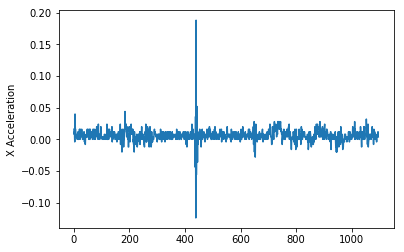

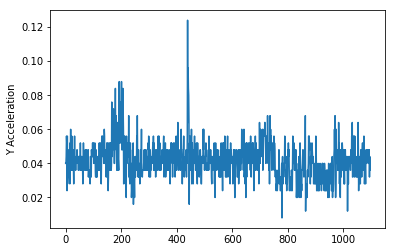

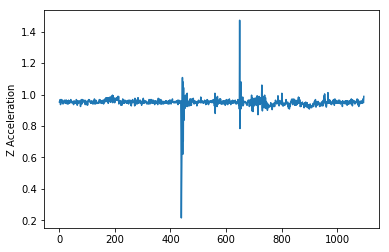

In [10]:
plt.plot([s['x'] for s in k])
plt.ylabel('X Acceleration')
plt.show()

plt.plot([s['y'] for s in k])
plt.ylabel('Y Acceleration')
plt.show()

plt.plot([s['z'] for s in k])
plt.ylabel('Z Acceleration')
plt.show()

In [ ]:
# select the correct i2c bus for this revision of Raspberry Pi
bus = smbus.SMBus(1)
# ADXL345 constants
# select the correct i2c bus for this revision of Raspberry Pi
revision = ([l[12:-1] for l in open('/proc/cpuinfo','r').readlines() if l[:8]=="Revision"]+['0000'])[0]
bus = smbus.SMBus(1 if int(revision, 16) >= 4 else 0)

# ADXL345 constants
EARTH_GRAVITY_MS2   = 9.80665
SCALE_MULTIPLIER    = 0.004

DATA_FORMAT         = 0x31
BW_RATE             = 0x2C
POWER_CTL           = 0x2D

BW_RATE_1600HZ      = 0x0F
BW_RATE_800HZ       = 0x0E
BW_RATE_400HZ       = 0x0D
BW_RATE_200HZ       = 0x0C
BW_RATE_100HZ       = 0x0B
BW_RATE_50HZ        = 0x0A
BW_RATE_25HZ        = 0x09

RANGE_2G            = 0x00
RANGE_4G            = 0x01
RANGE_8G            = 0x02
RANGE_16G           = 0x03

MEASURE             = 0x08
AXES_DATA           = 0x32


class ADXL345:

    address = None

    def __init__(self, address = 0x53):        
        self.address = address
        self.setBandwidthRate(BW_RATE_400HZ)
        self.setRange(RANGE_2G)
        self.enableMeasurement()

    def enableMeasurement(self):
        bus.write_byte_data(self.address, POWER_CTL, MEASURE)

    def setBandwidthRate(self, rate_flag):
        bus.write_byte_data(self.address, BW_RATE, rate_flag)

    # set the measurement range for 10-bit readings
    def setRange(self, range_flag):
        value = bus.read_byte_data(self.address, DATA_FORMAT)

        value &= ~0x0F;
        value |= range_flag;  
        value |= 0x08;

        bus.write_byte_data(self.address, DATA_FORMAT, value)
    
    # returns the current reading from the sensor for each axis
    #
    # parameter gforce:
    #    False (default): result is returned in m/s^2
    #    True           : result is returned in gs
    def getAxes(self, gforce = False):

        bytes = bus.read_i2c_block_data(self.address, AXES_DATA, 6)

                
        x = bytes[0] | (bytes[1] << 8)
        if(x & (1 << 16 - 1)):
            x = x - (1<<16)

        y = bytes[2] | (bytes[3] << 8)
        if(y & (1 << 16 - 1)):
            y = y - (1<<16)

        z = bytes[4] | (bytes[5] << 8)
        if(z & (1 << 16 - 1)):
            z = z - (1<<16)

        #x = x * SCALE_MULTIPLIER 
        #y = y * SCALE_MULTIPLIER
        #z = z * SCALE_MULTIPLIER

        #if gforce == False:
            #x = x * EARTH_GRAVITY_MS2
            #y = y * EARTH_GRAVITY_MS2
            #z = z * EARTH_GRAVITY_MS2

        #x = round(x, 4)
        #y = round(y, 4)
        #z = round(z, 4)


        
        return {"x": x, "y": y, "z": z}

if __name__ == "__main__":
    # if run directly we'll just create an instance of the class and output 
    # the current readings
    adxl345 = ADXL345()
    import time
    import matplotlib.pyplot as plt
    npoints=1000
    sfreqHz=1000

    xg=[0]*npoints
    yg=[0]*npoints
    zg=[0]*npoints

    i=1
    tic = time.time()
    while i<=npoints:
        axes = adxl345.getAxes(True)
        #print "   x = %.3fG" % ( axes['x'] )
        #print "   y = %.3fG" % ( axes['y'] )
        #print "   z = %.3fG" % ( axes['z'] )
      
        xg[i-1]=axes['x']
        yg[i-1]=axes['y']
        zg[i-1]=axes['z']

        i+=1
        time.sleep(1.0/sfreqHz)

            
    toc = time.time()
    print(" Measuremnt time= %.3fs" % ( toc-tic ))
    xg[:] = [j * SCALE_MULTIPLIER * EARTH_GRAVITY_MS2 for j in xg]
    yg[:] = [j * SCALE_MULTIPLIER * EARTH_GRAVITY_MS2 for j in yg]
    xg[:] = [j * SCALE_MULTIPLIER * EARTH_GRAVITY_MS2 for j in zg]

    plt.plot(xg)
    plt.ylabel('X Acceleration')
    plt.show()
    
    plt.plot(yg)
    plt.ylabel('Y Acceleration')
    plt.show()

    plt.plot(zg)
    plt.ylabel('Z Acceleration')
    plt.show()